# Deep Learning for Time Series Forecasting

**Deep learning** is a fashionable term referring to machine learning with artificial neural networks, particularly networks with many layers, so called **deep networks**. Advances in algorithm design, hardware (GPUs...), software tools (TensorFlow etc.) and the availability of training data on the internet have led to a renaissance for neural networks and the ability to train complex models to perform tasks that can rightly be called intelligent.

The following notebooks assume that you are familiar with the concepts of deep learning, including:
- artificial neurons
- artificial neural network architectures and layers
- activation functions
- training in batches and epochs
- ...

These concepts are the focus of our course **[📓 Deep Learning with TensorFlow](index/dlt2-intro-dl-tensorflow-2day.ipynb)**

## Preamble

In [1]:
import pandas
import numpy
import sklearn
import seaborn
import matplotlib

In [2]:
import forecast_lab

In [3]:
seaborn.set_style("ticks")
matplotlib.pyplot.rcParams["axes.grid"] = True
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)

## Neural Network Architectures for Timeseries Forecasting

As we have seen in the chapter [**📓 Forecasting with "Shallow" Learning**](../timeseries/mlts-forecasting-shallow.ipynb), _basically any regressor can be applied to recursive time series forecasting by transforming the time series data into a supervised learning problem._ That of course includes any neural network capable of regression, including **feed-forward neural networks**.

In this chapter however, we are going to foucs on types of networks especially suited for learning from sequences of data: **recurrent neural networks**. 


![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/640px-Recurrent_neural_network_unfold.svg.png) 
 [_Source_](https://commons.wikimedia.org/wiki/File:Recurrent_neural_network_unfold.svg) 

## Recurrent Neural Networks

Unlike feedforward neural networks, a **Recurrent Neural Network (RNN)** can use its internal state (i.e. memory) to process sequences of inputs.

Recurrent neural networks are therefore, in principle, very powerful in what they can learn and compute. One could say they are trainable general-purpose computers. To say that in technical language, they have been shown to be **Turing complete**, i.e. being able to implement **any algorithm**.

Like the one for playing Mario Kart:



In [4]:
from IPython.display import HTML
HTML("""
<iframe width="800" height="600" src="https://www.youtube.com/embed/Ipi40cb_RsI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")


### LSTM Networks

**Long Short-Term Memory** is a recurrent neural network architecture. LSTM networks contain LSTM units, composed of a **cell** and three **gates** - an **input gate**, an **output gate** and a **forget gate**. The cell can store values and the gates regulate read, write and delete operations on the cell.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/1024px-Peephole_Long_Short-Term_Memory.svg.png) Source: [Wikipedia](https://en.m.wikipedia.org/wiki/Long_short-term_memory)



This ability make LSTM especially suitable for processing sequences of data, including time series data for classification and prediction. LSTM cells that remember information make LSTM networks good at extracting patterns over long input sequences.


LSTM networks have achieved good performance on tasks like:

- speech recognition
- [language translation](http://translate.google.com)

An alternative architecture is the **GRU network**: **Gated Recurrent Units (GRU)** is a mechanism that works in a way similar to LSTM cells. They have fewer parameters, and are therefore easier to train that LSTMs, but also have more limited capabilities in comparison.

## Recurrent Neural Networks with `keras` 

`keras` provides a number of recurrent neural network architectures as layers:

- `keras.layers.SimpleRNN`: fully-connected RNN where the output is to be fed back to input
- `keras.layers.LSTM`: LSTM layer
- `keras.layers.GRU`: GRU layer

- stateful: True
- batch size: 1
- shuffle: False

In [5]:
import tensorflow
from tensorflow import keras

## Example: Engineering an LSTM Forecasting Model

Consider again the taxi trips dataset:

In [6]:
taxi_trips = forecast_lab.datasets.read_chicago_taxi_trips_daily()

In [7]:
taxi_trips.head()

,Trips
Date,
2013-01-01,96
2013-01-02,53
2013-01-03,61
2013-01-04,79
2013-01-05,76


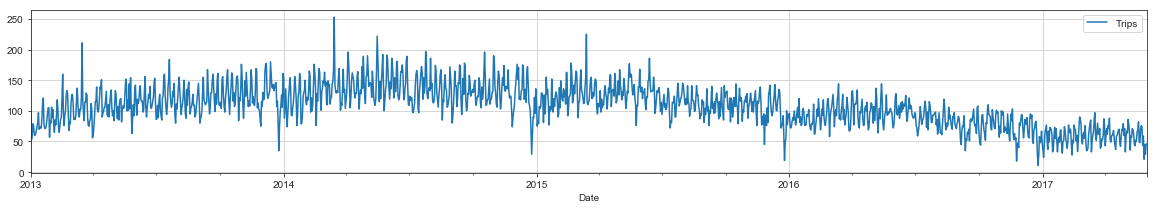

In [8]:
taxi_trips.plot()

### Data Preparation

More than other machine learning algorithms, neural networks are sensitive to the magnitude of the input values. It is generally recommended to **scale the input variables to the range of the activation function.** 


In [9]:
scaler = sklearn.preprocessing.MinMaxScaler(
    feature_range=(0,1)
)
scaler.fit(
    taxi_trips
)
scaled_values = scaler.transform(
    taxi_trips
)

/Users/cls/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
taxi_trips_scaled = pandas.Series(
    sklearn.preprocessing.MinMaxScaler(
        feature_range=(0,1)
    ).fit(
        taxi_trips
    ).transform(
        taxi_trips
    ).reshape(-1, ),
    index=taxi_trips.index,
)
taxi_trips_scaled.freq = "d"

/Users/cls/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
taxi_trips_scaled.head()

Date
2013-01-01    0.351240
2013-01-02    0.173554
2013-01-03    0.206612
2013-01-04    0.280992
2013-01-05    0.268595
dtype: float64

### Transforming to Supervised Learning Format

For training an LSTM network to forecast this time series, we are first preparing the training data by following the approach described in [**Forecasting with "Shallow" Learning**](../timeseries/mlts-forecasting-shallow.ipynb): Transforming the time series to a set of labelled data points:

In [12]:
w = 10

In [13]:
X_train, y_train = forecast_lab.core.transform_to_labelled_points(taxi_trips["Trips"][:1000], w)
X_test, y_test = forecast_lab.core.transform_to_labelled_points(taxi_trips["Trips"][1000:2000], 10)

In [14]:
X_train.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,96,53,61,79,76,62,60,63,68,75
1,53,61,79,76,62,60,63,68,75,80
2,61,79,76,62,60,63,68,75,80,97
3,79,76,62,60,63,68,75,80,97,70
4,76,62,60,63,68,75,80,97,70,74


In [15]:
y_train.head()

0    80
1    97
2    70
3    74
4    72
Name: y, dtype: int64

The NN expects the input to be in shape $(n, k, w)$, where:

- $n$: number of samples
- $k$: number of features per time step
- $w$: number of time steps in window

In [16]:
X_train.shape

(990, 10)

In [17]:
X_train = X_train.values.reshape(-1, 1, w)
X_test = X_test.values.reshape(-1, 1, w)

In [18]:
X_train.shape

(990, 1, 10)

In [19]:
X_train[0]

array([[96, 53, 61, 79, 76, 62, 60, 63, 68, 75]])

### Network Architecture

In [20]:
network = keras.models.Sequential(
    [
        keras.layers.LSTM(
            batch_input_shape=(1, 1, w),
            units=w,
            stateful=True,
        ),
        keras.layers.Dense(units=1,  activation="linear"),
    ]
)

Instructions for updating:
Colocations handled automatically by placer.


Note the parameters of the LSTM layer:

- **stateful**: The documentation states that  "If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch." We want the layer to maintain state across the training series.


In [21]:
network.compile(
    loss="mean_absolute_percentage_error",
    optimizer="adam"
)

In [22]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 10)                   840       
_________________________________________________________________
dense (Dense)                (1, 1)                    11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


### Training

**Training Parameters**


- **don't shuffle**: Order of data points matters, so keep the training data by passing `shuffle=False`
- **batch size: 1**
- **reset states**: When using a [stateful recurrent network](https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/) want it to maintain state during the epoch (one pass through the training series), but not between multiple passes - therefore the state is reset manually


In [23]:
epochs = 10

In [24]:
for i in range(epochs):
    network.fit(
        X_train, 
        y_train,
        batch_size=1,
        shuffle=False,
        epochs=1
    )
    network.reset_states()

Instructions for updating:
Use tf.cast instead.


990/990 [==============================] - 3s 3ms/sample - loss: 62.3219


In [25]:
X_train[-1]

array([[120, 129, 118, 111,  87, 115,  91, 114, 138, 106]])

In [26]:
network.predict(X_test[-1].reshape(1, 1, w), batch_size=1)

array([[24.9884]], dtype=float32)

### Wrapping the Network for Evaluation

We provide the `RNNWrapper` class to wrap the code above and make it easy to use the recurrent network in the `ForecastEvaluation`:

In [27]:
w = 50

In [28]:
lstm_forecasting = forecast_lab.RNNWrapper(
    estimator_class=keras.models.Sequential,
    estimator_params={
        "layers": [
            keras.layers.LSTM(
                batch_input_shape=(1, 1, w),
                units=w,
                stateful=True,
            ),
            keras.layers.Dense(units=1,  activation="linear"),
        ]
    },
    sliding_window_size=w
)

## Evaluation

In the following a few recurrent neural networks are passed to the `ForecastEvaluation`. Let's see whether they do well.

In [29]:
epochs = 30
w = 50

In [30]:
metrics = {
    "MAPE": forecast_lab.metrics.mean_absolute_percentage_error,
    "RSME": forecast_lab.metrics.root_mean_squared_error
}

======== iteration 0 ==========
650/650 [==============================] - 3s 5ms/sample - loss: 13.7988 - mean_squared_error: 0.0071


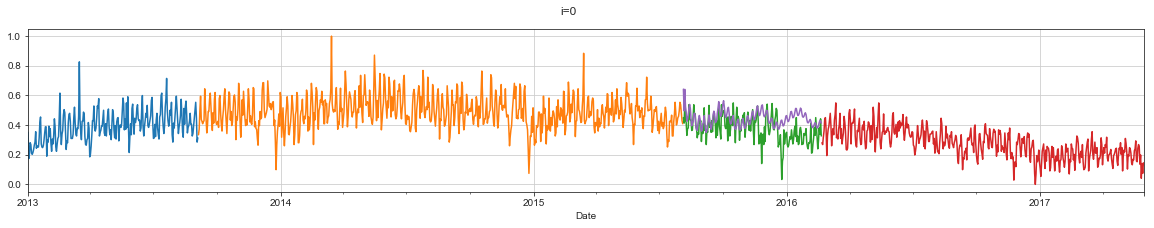

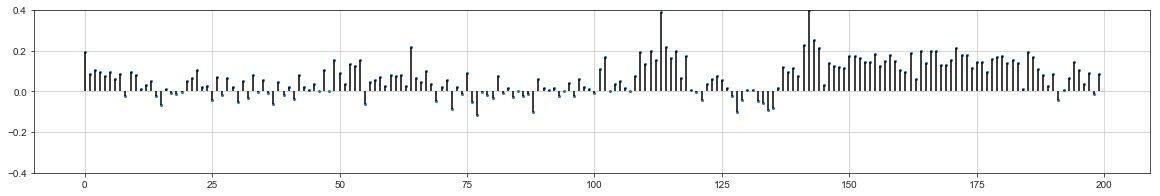

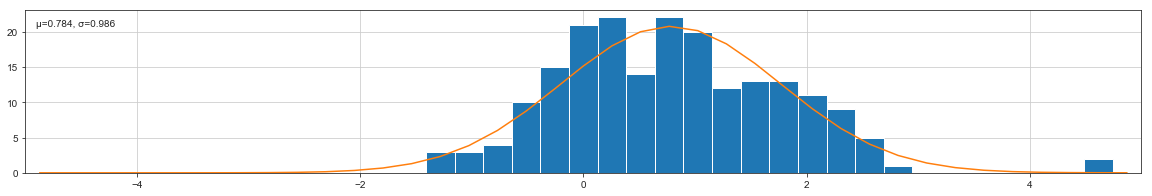

MAPE    32.740087
RSME     0.108649
dtype: float64

In [31]:
forecast_lab.ForecastEvaluation(
        ts=taxi_trips_scaled,
        forecasting=forecast_lab.RNNWrapper(
            estimator_class=keras.models.Sequential,
            estimator_params={
                "layers": [
                    keras.layers.LSTM(
                        batch_input_shape=(1, 1, w),
                        units=128,
                        stateful=True,
                    ),
                    keras.layers.Dense(units=1,  activation="linear"),
                ]
            },
            fit_params={
                "epochs": epochs,
            },
            sliding_window_size=w
        ),
        test_window_size=200,
        train_window_size=700,
        metrics=metrics
).evaluate(
    k=1, 
    plot_segments=True,
    plot_residuals=True,
    plot_pulls=True
).get_metrics().mean()

======== iteration 0 ==========
650/650 [==============================] - 1s 2ms/sample - loss: 24.0181 - mean_squared_error: 0.0171


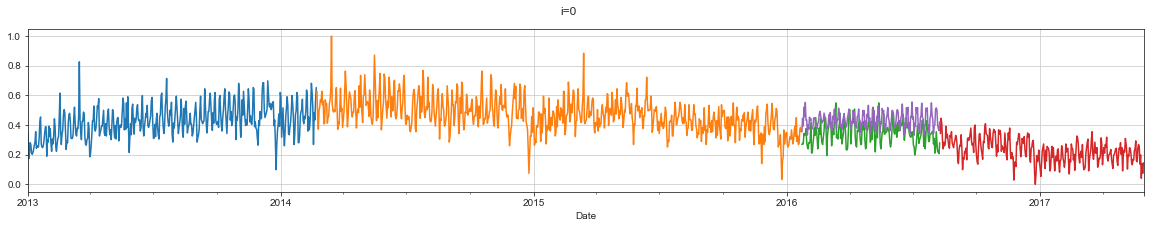

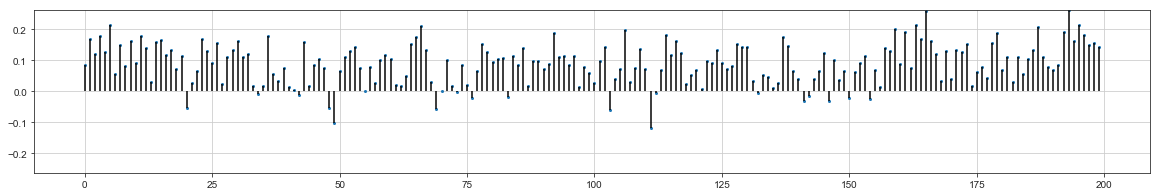

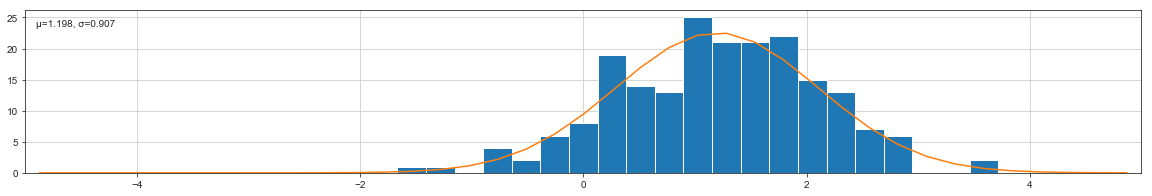

MAPE    31.218487
RSME     0.110854
dtype: float64

In [32]:
forecast_lab.ForecastEvaluation(
        ts=taxi_trips_scaled,
        forecasting=forecast_lab.RNNWrapper(
            estimator_class=keras.models.Sequential,
            estimator_params={
                "layers": [
                    keras.layers.SimpleRNN(
                        batch_input_shape=(1, 1, w),
                        units=128,
                        stateful=True,
                    ),
                    keras.layers.Dense(units=1, activation="linear"),
                ]
            },
            fit_params={
                "epochs": epochs,
            },
            sliding_window_size=w
        ),

        test_window_size=200,
        train_window_size=700,
        metrics=metrics,
).evaluate(
    k=1, 
    plot_segments=True,
    plot_residuals=True,
    plot_pulls=True
).get_metrics().mean()

======== iteration 0 ==========
650/650 [==============================] - 2s 4ms/sample - loss: 15.2642 - mean_squared_error: 0.0084


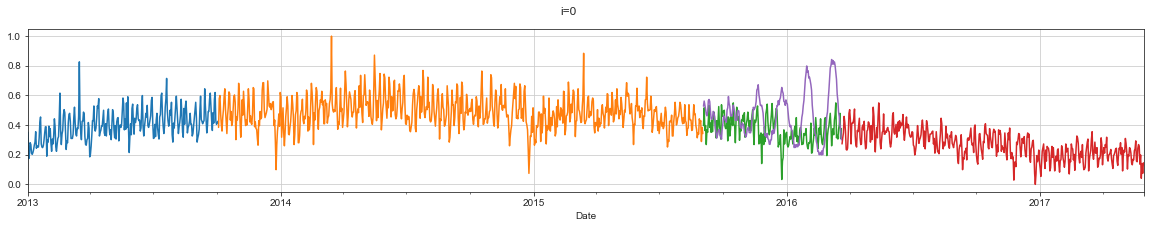

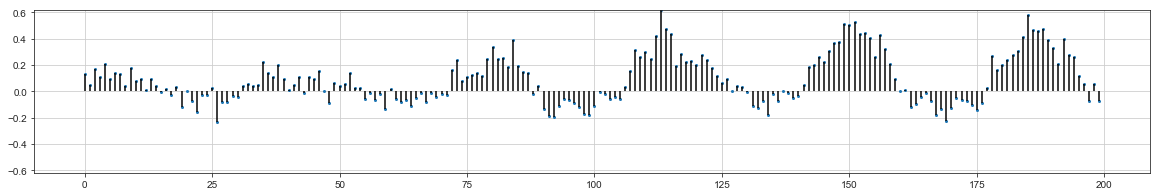

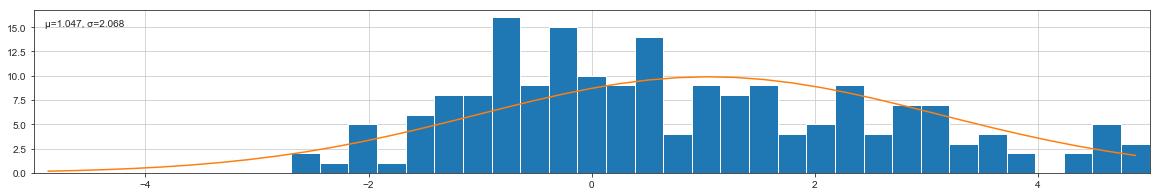

MAPE    55.854083
RSME     0.200804
dtype: float64

In [35]:
forecast_lab.ForecastEvaluation(
        ts=taxi_trips_scaled,
        forecasting=forecast_lab.RNNWrapper(
            estimator_class=keras.models.Sequential,
            estimator_params={
                "layers": [
                    keras.layers.GRU(
                        batch_input_shape=(1, 1, w),
                        units=128,
                        stateful=True,
                    ),
                    keras.layers.Dense(units=1,  activation="linear"),
                ]
            },
            fit_params={
                "epochs": epochs,
            },
            sliding_window_size=w
        ),

        test_window_size=200,
        train_window_size=700,
        metrics=metrics
).evaluate(
    k=1, 
    plot_segments=True,
    plot_residuals=True,
    plot_pulls=True
).get_metrics().mean()

## Model Engineering Options

With neural networks we enter a vast space of possibilities for engineering better models. Parameters to experiment with include:
- network architecture: combine RNN layers with the full range of neural network architecture patterns (layers, activation functions...) 
- training parameters
- preprocessing: experiment with [different scaling methods](https://stats.stackexchange.com/questions/7757/data-normalization-and-standardization-in-neural-networks)
- ...

## References

- [Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
- [Meaning (and proof) of “RNN can approximate any algorithm”](https://stats.stackexchange.com/questions/220907/meaning-and-proof-of-rnn-can-approximate-any-algorithm)
- [Understanding Stateful LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/)

---
_This notebook is licensed under a [Creative Commons Attribution 4.0 International License (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Copyright © 2019 [Point 8 GmbH](https://point-8.de)_